In [ ]:
!pip install numpy==1.23.5  # Versión estable compatible
!pip install pmdarima==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df_estadistico = pd.read_csv('/content/df_estadistico.csv',
                 encoding='latin-1',
                 sep=',',
                 decimal='.')



In [ ]:
from collections import defaultdict

fechas_completas = pd.date_range(start='2014-01-01', end='2024-12-01', freq='MS')
n_total_meses = len(fechas_completas)

series_dict = {}
series_faltantes = {}
series_descartadas = {}

# Recalcular agrupado limpio
df_agrupado = df_estadistico.groupby(['Fecha', 'Grupo_Consumo', 'Latitud', 'Longitud'])['Energia_GWh'].sum().reset_index()

for key, grupo in df_agrupado.groupby(['Grupo_Consumo', 'Latitud', 'Longitud']):
    serie = grupo[['Fecha', 'Energia_GWh']].copy()
    serie['Fecha'] = pd.to_datetime(serie['Fecha'])
    serie = serie.drop_duplicates(subset='Fecha')
    serie = serie.set_index('Fecha').sort_index()
    serie = serie[~serie.index.duplicated(keep='first')]
    serie = serie.asfreq('MS')
    serie = serie.reindex(fechas_completas)

    # Detectar fechas faltantes originales
    fechas_faltantes = serie[serie['Energia_GWh'].isna()].index
    series_faltantes[key] = fechas_faltantes

    # 🔍 Analizar por año
    faltantes_por_anio = defaultdict(int)
    for fecha in fechas_faltantes:
        faltantes_por_anio[fecha.year] += 1

    # Contar cuántos años tienen > 2 meses faltantes
    años_invalidos = sum(1 for f in faltantes_por_anio.values() if f > 2)

    if años_invalidos > 2:
        series_descartadas[key] = fechas_faltantes
        continue  # ❌ Descartar esta serie

    # ✅ Mantener: interpolar
    serie = serie.interpolate(method='linear')
    serie = serie.fillna(0)
    series_dict[key] = serie

In [ ]:
print(f"🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: {len(series_descartadas)}")
for i, (clave, fechas) in enumerate(series_descartadas.items()):
    grupo, lat, lon = clave
    print(f"{i+1}. {grupo} - ({lat}, {lon}) → {len(fechas)} fechas faltantes")
    if i >= 4: break


🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: 1
1. Alumbrado PÃºblico - (0.5022, -77.8857) → 71 fechas faltantes


In [ ]:
n_total_series = len(series_dict) + len(series_descartadas)

print("📊 RESUMEN DE PROCESAMIENTO DE SERIES")
print("──────────────────────────────────────────")
print(f"🔢 Total de series analizadas:     {n_total_series}")
print(f"✅ Series conservadas (interpoladas): {len(series_dict)}")
print(f"❌ Series descartadas (>2 años incompletos): {len(series_descartadas)}")
print("──────────────────────────────────────────")


📊 RESUMEN DE PROCESAMIENTO DE SERIES
──────────────────────────────────────────
🔢 Total de series analizadas:     116
✅ Series conservadas (interpoladas): 115
❌ Series descartadas (>2 años incompletos): 1
──────────────────────────────────────────


In [ ]:
from pmdarima import auto_arima

def obtener_parametros_sarima(serie):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()
    y = serie['Energia_GWh']

    modelo = auto_arima(y,
                        start_p=0, start_q=0,
                        max_p=3, max_q=3,
                        d=None,
                        seasonal=True,     # ⭐ Activamos SARIMA
                        m=12,              # ⭐ Periodo estacional mensual
                        start_P=0, start_Q=0,
                        max_P=2, max_Q=2,
                        D=None,
                        trace=True,
                        stepwise=True,
                        suppress_warnings=True,
                        error_action="ignore")

    orden = modelo.order          # (p, d, q)
    orden_seasonal = modelo.seasonal_order  # (P, D, Q, s)
    print(f"→ SARIMA{orden} x {orden_seasonal}")
    return orden, orden_seasonal


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

parametros_por_serie = {}

for clave, serie in series_dict.items():
    try:
        print(f"📈 Analizando {clave}")
        orden, orden_seasonal = obtener_parametros_sarima(serie)
        parametros_por_serie[clave] = (orden, orden_seasonal)
    except Exception as e:
        print(f"❌ Error en {clave}: {e}")


📈 Analizando ('Alumbrado PÃºblico', -3.9931, -79.2042)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=83.361, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-3.654, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24.856, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=81.423, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-20.124, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-26.779, Time=0.92 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-25.432, Time=0.45 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-25.044, Time=1.61 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-23.365, Time=1.10 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-24.664, Time=1.96 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=-25.344, Time=2.41 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=75.249, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-41.828, 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def ajustar_y_predecir_sarima(serie, orden, orden_seasonal):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()

    train = serie.loc[:'2023-12-01']
    test = serie.loc['2024-01-01':'2024-12-01']

    modelo = SARIMAX(train,
                     order=orden,
                     seasonal_order=orden_seasonal,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

    resultado = modelo.fit(disp=False)
    pred = resultado.forecast(steps=len(test))

    fechas = test.index
    df_pred = pd.DataFrame({
        'Fecha': fechas,
        'Prediccion_GWh': pred.values,
        'Real_GWh': test['Energia_GWh'].values
    })

    # Métricas
    denominador = test['Energia_GWh'].replace(0, np.nan)
    mae = mean_absolute_error(test['Energia_GWh'], pred)
    rmse = np.sqrt(mean_squared_error(test['Energia_GWh'], pred))
    mape = np.mean(np.abs((test['Energia_GWh'] - pred) / denominador)) * 100

    print(f"SARIMA{orden} x {orden_seasonal} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
    return df_pred


In [ ]:
todas_las_predicciones = []
warnings.filterwarnings("ignore", category=FutureWarning)

for clave, serie in series_dict.items():
    if clave in parametros_por_serie:
        orden, orden_seasonal = parametros_por_serie[clave]
        grupo, lat, lon = clave
        try:
            print(f"🔁 Procesando {grupo} - ({lat}, {lon}) con SARIMA{orden} x {orden_seasonal}")
            df_pred = ajustar_y_predecir_sarima(serie, orden=orden, orden_seasonal=orden_seasonal)
            df_pred['Grupo_Consumo'] = grupo
            df_pred['Latitud'] = lat
            df_pred['Longitud'] = lon
            todas_las_predicciones.append(df_pred)
        except Exception as e:
            print(f"❌ Error en {clave}: {e}")


🔁 Procesando Alumbrado PÃºblico - (-3.9931, -79.2042) con SARIMA(1, 1, 1) x (2, 0, 2, 12)
SARIMA(1, 1, 1) x (2, 0, 2, 12) | MAE: 0.28 | RMSE: 0.48 | MAPE: 6.51%
🔁 Procesando Alumbrado PÃºblico - (-3.2596, -79.9585) con SARIMA(0, 1, 3) x (0, 0, 0, 12)
SARIMA(0, 1, 3) x (0, 0, 0, 12) | MAE: 3.41 | RMSE: 3.51 | MAPE: 40.78%
🔁 Procesando Alumbrado PÃºblico - (-2.9006, -79.0045) con SARIMA(1, 1, 1) x (1, 0, 1, 12)
SARIMA(1, 1, 1) x (1, 0, 1, 12) | MAE: 0.15 | RMSE: 0.20 | MAPE: 1.24%
🔁 Procesando Alumbrado PÃºblico - (-2.5489, -78.9382) con SARIMA(1, 1, 2) x (0, 0, 0, 12)
SARIMA(1, 1, 2) x (0, 0, 0, 12) | MAE: 0.05 | RMSE: 0.06 | MAPE: 4.06%
🔁 Procesando Alumbrado PÃºblico - (-2.2301, -80.8599) con SARIMA(3, 1, 1) x (0, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1) x (0, 0, 0, 12) | MAE: 1.59 | RMSE: 2.85 | MAPE: 340.24%
🔁 Procesando Alumbrado PÃºblico - (-2.1709, -79.9224) con SARIMA(0, 1, 2) x (1, 0, 0, 12)
SARIMA(0, 1, 2) x (1, 0, 0, 12) | MAE: 2.78 | RMSE: 5.58 | MAPE: 9.22%
🔁 Procesando Alumbrado PÃºblico - (-1.7946, -79.5342) con SARIMA(1, 0, 2) x (0, 0, 0, 12)
SARIMA(1, 0, 2) x (0, 0, 0, 12) | MAE: 0.75 | RMSE: 1.06 | MAPE: 329.36%
🔁 Procesando Alumbrado PÃºblico - (-1.6708, -78.6569) con SARIMA(0, 1, 1) x (0, 0, 0, 12)
SARIMA(0, 1, 1) x (0, 0, 0, 12) | MAE: 0.31 | RMSE: 0.56 | MAPE: 10.24%
🔁 Procesando Alumbrado PÃºblico - (-1.6167, -79.0) con SARIMA(0, 1, 0) x (1, 0, 1, 12)
SARIMA(0, 1, 0) x (1, 0, 1, 12) | MAE: 0.03 | RMSE: 0.04 | MAPE: 1.87%
🔁 Procesando Alumbrado PÃºblico - (-1.2543, -78.622) con SARIMA(3, 1, 1) x (0, 0, 0, 12)
SARIMA(3, 1, 1) x (0, 0, 0, 12) | MAE: 0.71 | RMSE: 1.01 | MAPE: 8.87%
🔁 Procesando Alumbrado PÃºblico - (-0.9676, -80.7089) con SARIMA(1, 0, 1) x (0, 1, 0, 12)
SARIMA(1, 0, 1) x (0, 1, 0, 12) |

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1) x (0, 0, 0, 12) | MAE: 0.16 | RMSE: 0.17 | MAPE: 9.00%
🔁 Procesando Comercial - (-2.2301, -80.8599) con SARIMA(1, 0, 0) x (1, 0, 0, 12)
SARIMA(1, 0, 0) x (1, 0, 0, 12) | MAE: 0.71 | RMSE: 0.80 | MAPE: 11.09%
🔁 Procesando Comercial - (-2.1709, -79.9224) con SARIMA(1, 0, 0) x (2, 0, 1, 12)
SARIMA(1, 0, 0) x (2, 0, 1, 12) | MAE: 11.70 | RMSE: 16.32 | MAPE: 9.95%
🔁 Procesando Comercial - (-1.7946, -79.5342) con SARIMA(0, 1, 2) x (2, 0, 1, 12)
SARIMA(0, 1, 2) x (2, 0, 1, 12) | MAE: 2.12 | RMSE: 3.09 | MAPE: 25.69%
🔁 Procesando Comercial - (-1.6708, -78.6569) con SARIMA(0, 1, 3) x (0, 0, 0, 12)
SARIMA(0, 1, 3) x (0, 0, 0, 12) | MAE: 0.35 | RMSE: 0.45 | MAPE: 6.32%
🔁 Procesando Comercial - (-1.6167, -79.0) con SARIMA(2, 1, 1) x (1, 0, 0, 12)
SARIMA(2, 1, 1) x (1, 0, 0, 12) | MAE: 0.09 | RMSE: 0.14 | MAPE: 8.07%
🔁 Procesando Comercial - (-1.491, -77.9916) con SARIMA(1, 1, 2) x (0, 0, 0, 12)
SARIMA(1, 1, 2) x (0, 0, 0, 12) | MAE: 0.06 | RMSE: 0.08 | MAPE: 3.91%
🔁 Procesando Come

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2) x (0, 0, 0, 12) | MAE: 0.03 | RMSE: 0.03 | MAPE: 5.92%
🔁 Procesando Industrial - (-1.2543, -78.622) con SARIMA(1, 0, 0) x (0, 0, 1, 12)
SARIMA(1, 0, 0) x (0, 0, 1, 12) | MAE: 0.48 | RMSE: 0.62 | MAPE: 5.24%
🔁 Procesando Industrial - (-1.0515, -77.732) con SARIMA(0, 1, 2) x (0, 0, 0, 12)
SARIMA(0, 1, 2) x (0, 0, 0, 12) | MAE: 0.15 | RMSE: 0.22 | MAPE: 10.60%
🔁 Procesando Industrial - (-0.9676, -80.7089) con SARIMA(0, 1, 1) x (2, 0, 0, 12)
SARIMA(0, 1, 1) x (2, 0, 0, 12) | MAE: 4.44 | RMSE: 8.33 | MAPE: 139.52%
🔁 Procesando Industrial - (-0.9538, -90.9656) con SARIMA(2, 1, 1) x (0, 0, 0, 12)
SARIMA(2, 1, 1) x (0, 0, 0, 12) | MAE: 0.01 | RMSE: 0.01 | MAPE: 11.73%
🔁 Procesando Industrial - (-0.9381, -78.614) con SARIMA(1, 0, 0) x (0, 0, 0, 12)
SARIMA(1, 0, 0) x (0, 0, 0, 12) | MAE: 5.20 | RMSE: 6.00 | MAPE: 24.64%
🔁 Procesando Industrial - (-0.6743, -76.9864) con SARIMA(1, 0, 1) x (0, 0, 0, 12)
SARIMA(1, 0, 1) x (0, 0, 0, 12) | MAE: 0.15 | RMSE: 0.17 | MAPE: 10.22%
🔁 Proces

In [ ]:
print(f"✅ Total de subseries procesadas exitosamente: {len(todas_las_predicciones)}")


✅ Total de subseries procesadas exitosamente: 115


In [ ]:
df_total_pred = pd.concat(todas_las_predicciones, ignore_index=True)

# Sumar todas las predicciones mensuales para obtener la curva nacional
df_nacional_predicho = df_total_pred.groupby('Fecha')['Prediccion_GWh'].sum().reset_index()
# Calcular la curva nacional real (suma de todas las series por mes)
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()
# Asegurar tipo datetime para ambas columnas 'Fecha'
df_nacional_predicho['Fecha'] = pd.to_datetime(df_nacional_predicho['Fecha'])
df_nacional_real['Fecha'] = pd.to_datetime(df_nacional_real['Fecha'])

# Ahora sí: unir ambas curvas
df_comparacion = pd.merge(df_nacional_predicho, df_nacional_real, on='Fecha', how='inner')
df_comparacion.columns = ['Fecha', 'Prediccion_GWh', 'Real_GWh']


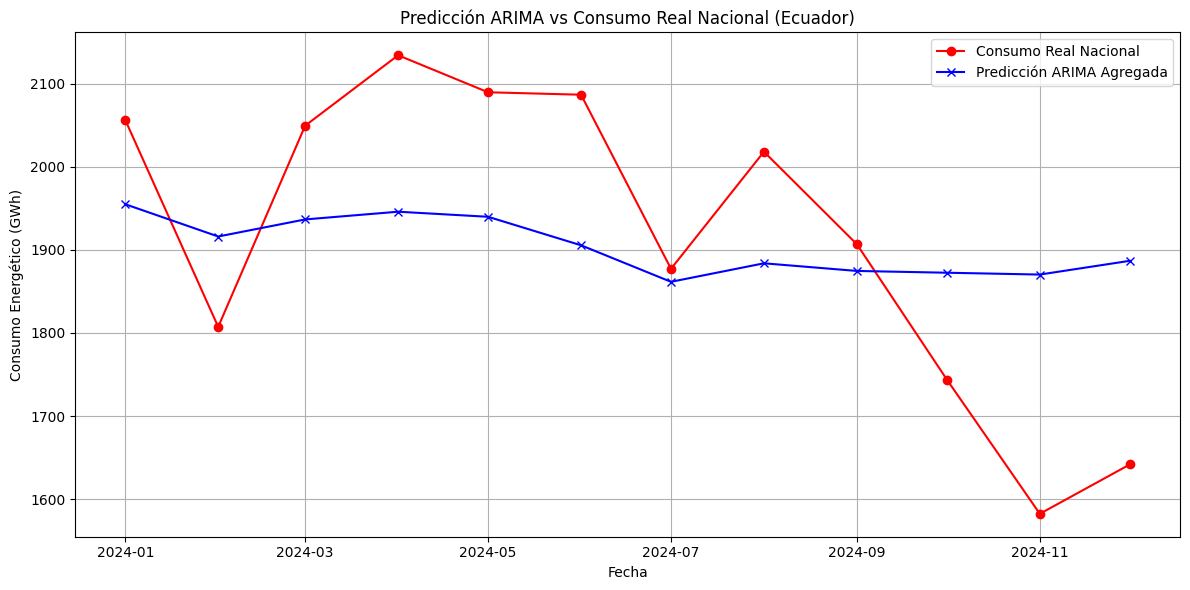

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Real_GWh'], label='Consumo Real Nacional', color='red', marker='o')
plt.plot(df_comparacion['Fecha'], df_comparacion['Prediccion_GWh'], label='Predicción ARIMA Agregada', color='blue', marker='x')
plt.title('Predicción ARIMA vs Consumo Real Nacional (Ecuador)')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético (GWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


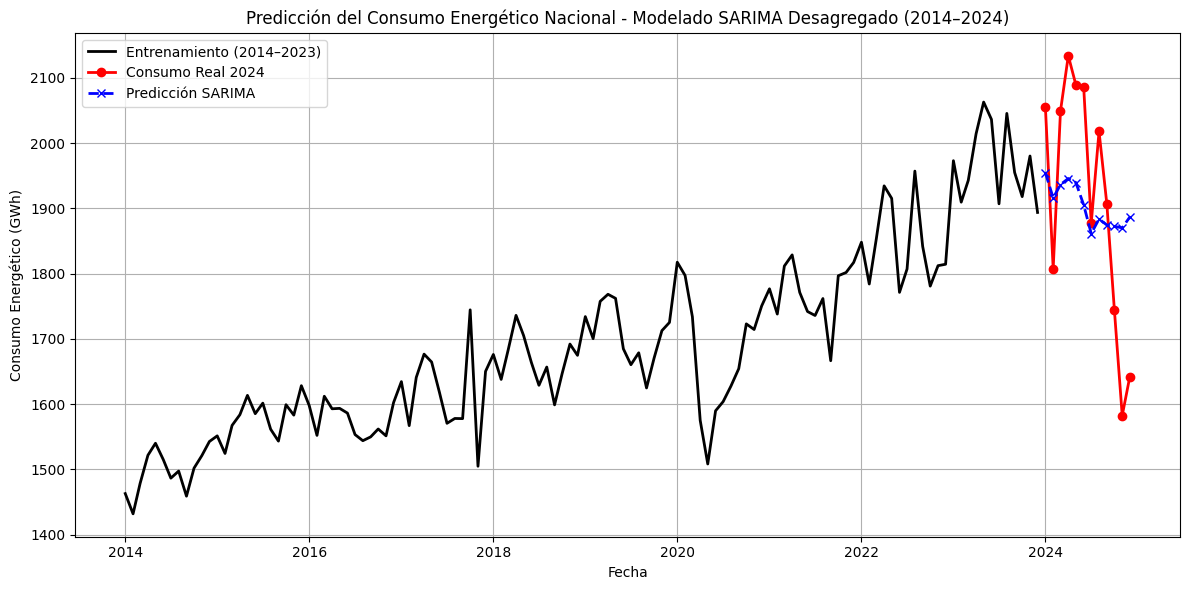

In [ ]:
# 1. Asegúrate de tener toda la curva real desde 2014
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

# 2. Convertir fechas a datetime si no lo están
df_nacional_predicho["Fecha"] = pd.to_datetime(df_nacional_predicho["Fecha"])
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])

# 3. Unir predicción con la curva real
df_comparacion = pd.merge(df_nacional_real, df_nacional_predicho, on="Fecha", how="left")
df_comparacion.columns = ["Fecha", "Real_GWh", "Prediccion_GWh"]

# 4. Separar fases
df_entrenamiento = df_comparacion[df_comparacion["Fecha"].dt.year < 2024]
df_test_real = df_comparacion[df_comparacion["Fecha"].dt.year == 2024]
df_test_pred = df_test_real.dropna(subset=["Prediccion_GWh"])  # asegurar solo fechas con predicción

# 5. Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_entrenamiento["Fecha"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014–2023)", color="black", linewidth=2)

plt.plot(df_test_real["Fecha"], df_test_real["Real_GWh"],
         label="Consumo Real 2024", color="red", marker="o", linewidth=2)

plt.plot(df_test_pred["Fecha"], df_test_pred["Prediccion_GWh"],
         label="Predicción SARIMA ", color="blue", linestyle="--", marker="x", linewidth=2)

plt.title("Predicción del Consumo Energético Nacional - Modelado SARIMA Desagregado (2014–2024)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energético (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Filtrar los datos de test: solo 2023
df_test_2023 = df_comparacion[df_comparacion['Fecha'].dt.year == 2024].copy()

# 2. Extraer reales y predichos
y_real = df_test_2023['Real_GWh']
y_pred = df_test_2023['Prediccion_GWh']

# 3. Calcular métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mape = np.mean(np.abs((y_real - y_pred) / y_real.replace(0, np.nan))) * 100  # evitar división por cero
r2 = r2_score(y_real, y_pred)

# 4. Mostrar resultados
print("📊 MÉTRICAS DE ERROR – ARIMA (2023)")
print("────────────────────────────────────")
print(f"✅ MAE  : {mae:.2f} GWh")
print(f"✅ RMSE : {rmse:.2f} GWh")
print(f"✅ MAPE : {mape:.2f} %")
print(f"✅ R²   : {r2:.4f}")


📊 MÉTRICAS DE ERROR – ARIMA (2023)
────────────────────────────────────
✅ MAE  : 140.44 GWh
✅ RMSE : 159.20 GWh
✅ MAPE : 7.56 %
✅ R²   : 0.2081
